# Exploration

In [7]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from darts import TimeSeries
from helpers import *
sns.set_theme(context="notebook", style="whitegrid", color_codes=True, rc={"figure.figsize": (6, 2)})

### Load data

In [8]:
date = "20240102"
atm_strike = get_option_atm_strike(date)
quotes = get_option_quotes(date)
quotes

atm strike: 4745000
Number of quotes loaded: 504021


,ms_of_day,strike,call_mid,put_mid
ts,,,,
2024-01-02 09:30:00,34200000,4695000,0.000,0.00
2024-01-02 09:30:00,34200000,4700000,0.000,0.00
2024-01-02 09:30:00,34200000,4705000,0.000,0.00
2024-01-02 09:30:00,34200000,4710000,0.000,0.00
2024-01-02 09:30:00,34200000,4715000,0.000,0.00
...,...,...,...,...
2024-01-02 16:10:00,58200000,4775000,0.025,31.55
2024-01-02 16:10:00,58200000,4780000,0.025,36.55
2024-01-02 16:10:00,58200000,4785000,0.025,41.55


In [9]:
df = quotes[quotes['strike'] == atm_strike].copy()
df = df.drop(columns=['strike', 'ms_of_day', 'put_mid'])

                     call_mid
ts                           
2024-01-02 09:30:00       0.0
2024-01-02 09:30:01       0.0
2024-01-02 09:30:02       0.0
2024-01-02 09:30:03       0.0


<Axes: xlabel='ts'>

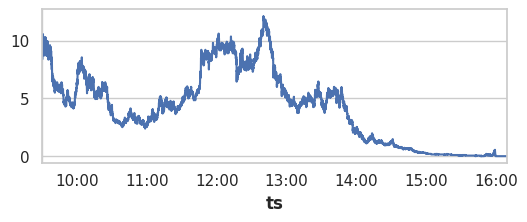

In [10]:
# Remove for rows where value is zero.  Should only be start of the day
zero_call_mid_rows = df[df['call_mid'] == 0]
print(zero_call_mid_rows)
df = df[df['call_mid'] != 0]
df.call_mid.plot()

### Trend, mean reversion, or random walk
* < 0.5: Mean-reverting
* 0.5: Random walk
* \> 0.5: Trending

Interpretation
```
20 lags:   0.3801 — Some mean-reverting     
100 lags:  0.3916 — Some mean-reverting behavior.
250 lags:  0.4332 — Approaching random walk.
```

In [11]:
for lag in [20, 100, 250, 500, 1000]:
    hurst_exp = get_hurst_exponent(df["call_mid"].values, lag)
    print(f"Hurst exponent with {lag} lags: {hurst_exp:.4f}")

Hurst exponent with 20 lags: 0.4807
Hurst exponent with 100 lags: 0.4689
Hurst exponent with 250 lags: 0.4852
Hurst exponent with 500 lags: 0.5122
Hurst exponent with 1000 lags: 0.5205


### Volatility Clustering with log_rtn
Note. **Lots of action in last hour**

<Axes: xlabel='ts'>

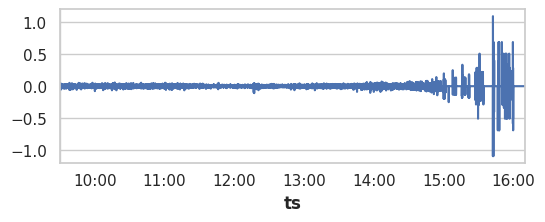

In [14]:
df["log_rtn"] = np.log(df["call_mid"]/df["call_mid"].shift(1))
df = df[["call_mid", "log_rtn"]].dropna()
df["log_rtn"].plot()

### Non-Gaussian distribution of returns

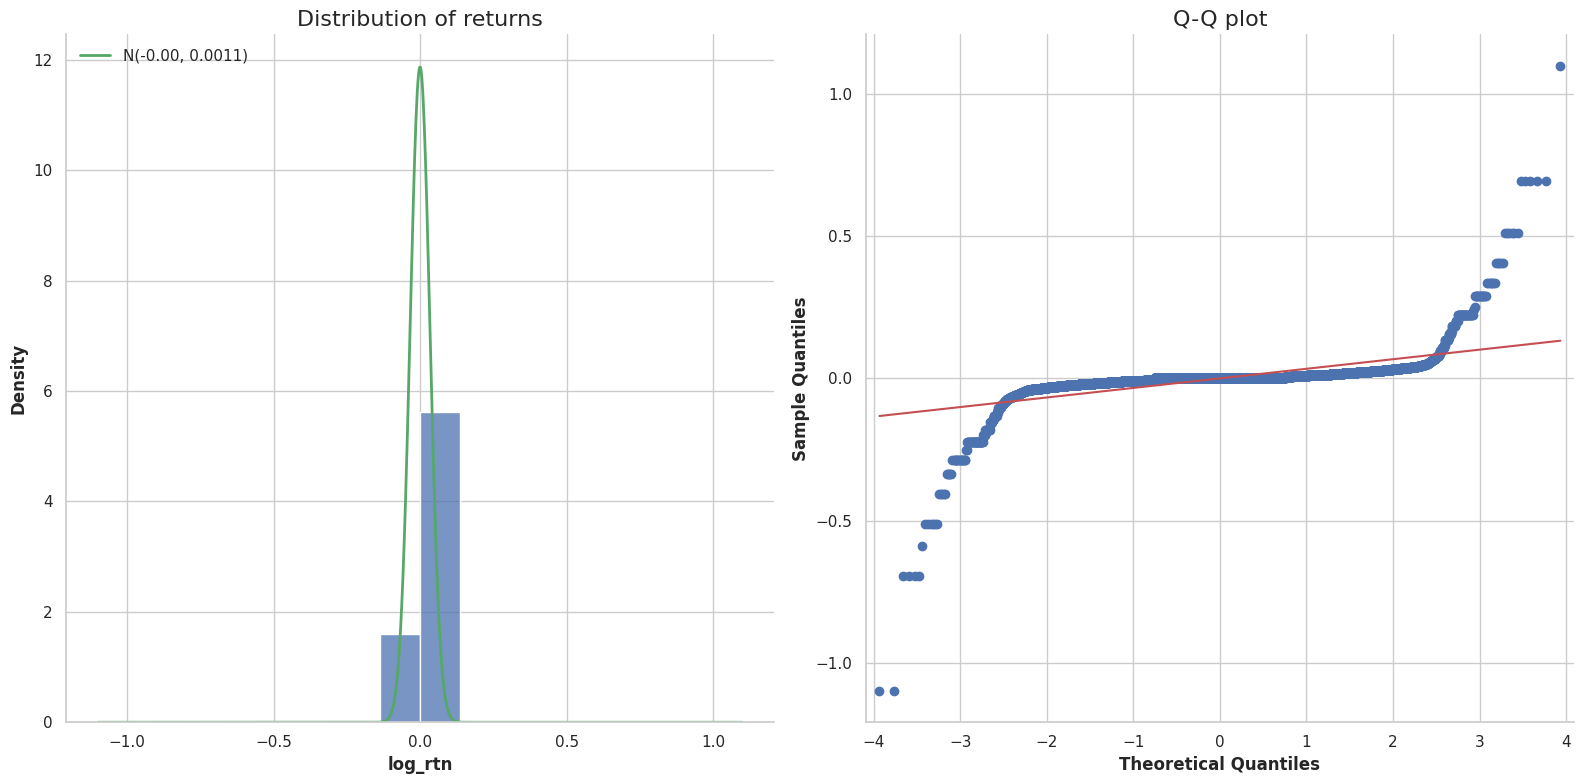

In [15]:
# Calculate the Normal PDF using the mean and standard deviation of the observed returns:
r_range = np.linspace(min(df["log_rtn"]), max(df["log_rtn"]), num=1000)
mu = df["log_rtn"].mean()
sigma = df["log_rtn"].std()
norm_pdf = scs.norm.pdf(r_range, loc=mu, scale=sigma)   

# Plot the histogram and the Q-Q Plot:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# histogram
sns.histplot(df.log_rtn, kde=False, stat='density', ax=ax[0])
ax[0].set_title("Distribution of returns", fontsize=16)                                                    
ax[0].plot(r_range, norm_pdf, "g", lw=2, label=f"N({mu:.2f}, {sigma**2:.4f})")
ax[0].legend(loc="upper left");

# Q-Q plot
qq = sm.qqplot(df.log_rtn.values, line="s", ax=ax[1])
ax[1].set_title("Q-Q plot", fontsize = 16)

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_4_11", dpi=200);

### Stationarity and Autocorrelation
**Critical levels**
* ADF.  1%: -3.43, 5%: -2.86, and 10%: -2.57
* KPSS. 1%: ~0.739, 5%: ~0.463, and 10%: ~0.347


Run #1: df.call_mid
* ADF test statistic: -1.97 (p-val: 0.30).    > critical levels means **non-stationary**.
* KPSS test statistic: 13.08 (p-val: 0.01).   > critical levels means **non-stationary**.
* **Correlation at 5 intervals**

Run #2: df.call_mid.diff().dropna()
* ADF test statistic: -112.36 (p-val: 0.0).    < critical levels means **stationary**.
* KPSS test statistic: 0.07 (p-val: 0.10).   < critical levels means **stationary**.
* No correlation

Run #3: df.log_rtn
* ADF test statistic: -26.04 (p-val: 0.00)   < critical levels means **stationary**
* KPSS test statistic: 0.18 (p-val: 0.10)   < critical levels means **stationary**
* Correlation at 1 interval

ADF test statistic: -26.04 (p-val: 0.00)
KPSS test statistic: 0.18 (p-val: 0.10)


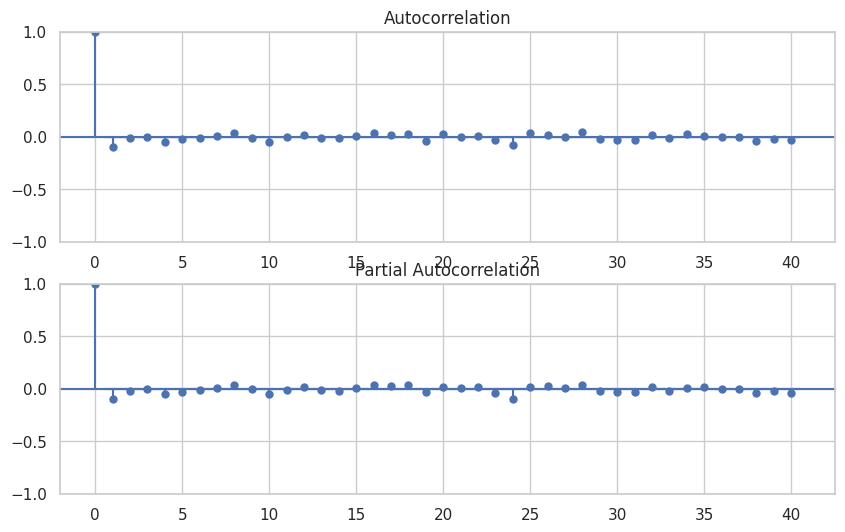

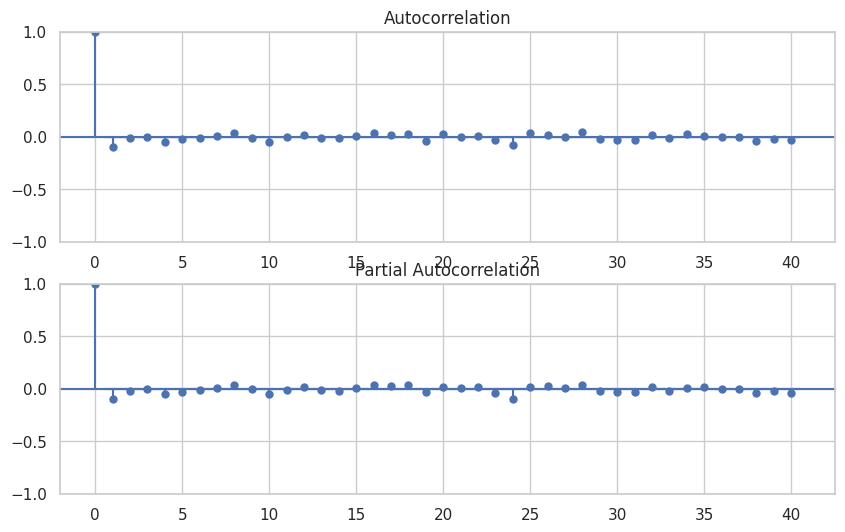

In [16]:
test_autocorrelation(df['log_rtn'])

#### Check seasonality

In [11]:
from darts import TimeSeries
from darts.utils.statistics import plot_acf, check_seasonality

df = create_sinewave()
series = TimeSeries.from_dataframe(df, value_cols='close')

for m in range(2, 25):
    is_seasonal, period = check_seasonality(series, m=m, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

### Absence of autocorrelation in returns

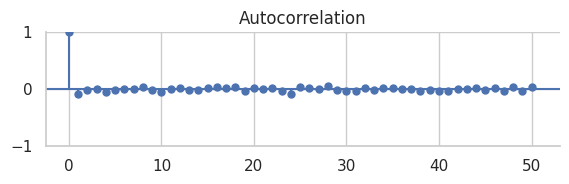

In [ ]:
# Define the parameters for creating the autocorrelation plots:
N_LAGS = 50
SIGNIFICANCE_LEVEL = 0.05

# Run the following code to create ACF plot of log returns:
acf = smt.graphics.plot_acf(df["log_rtn"], lags=N_LAGS, alpha=SIGNIFICANCE_LEVEL)

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_4_13", dpi=200);


### Small and decreasing autocorrelation in squared/absolute returns

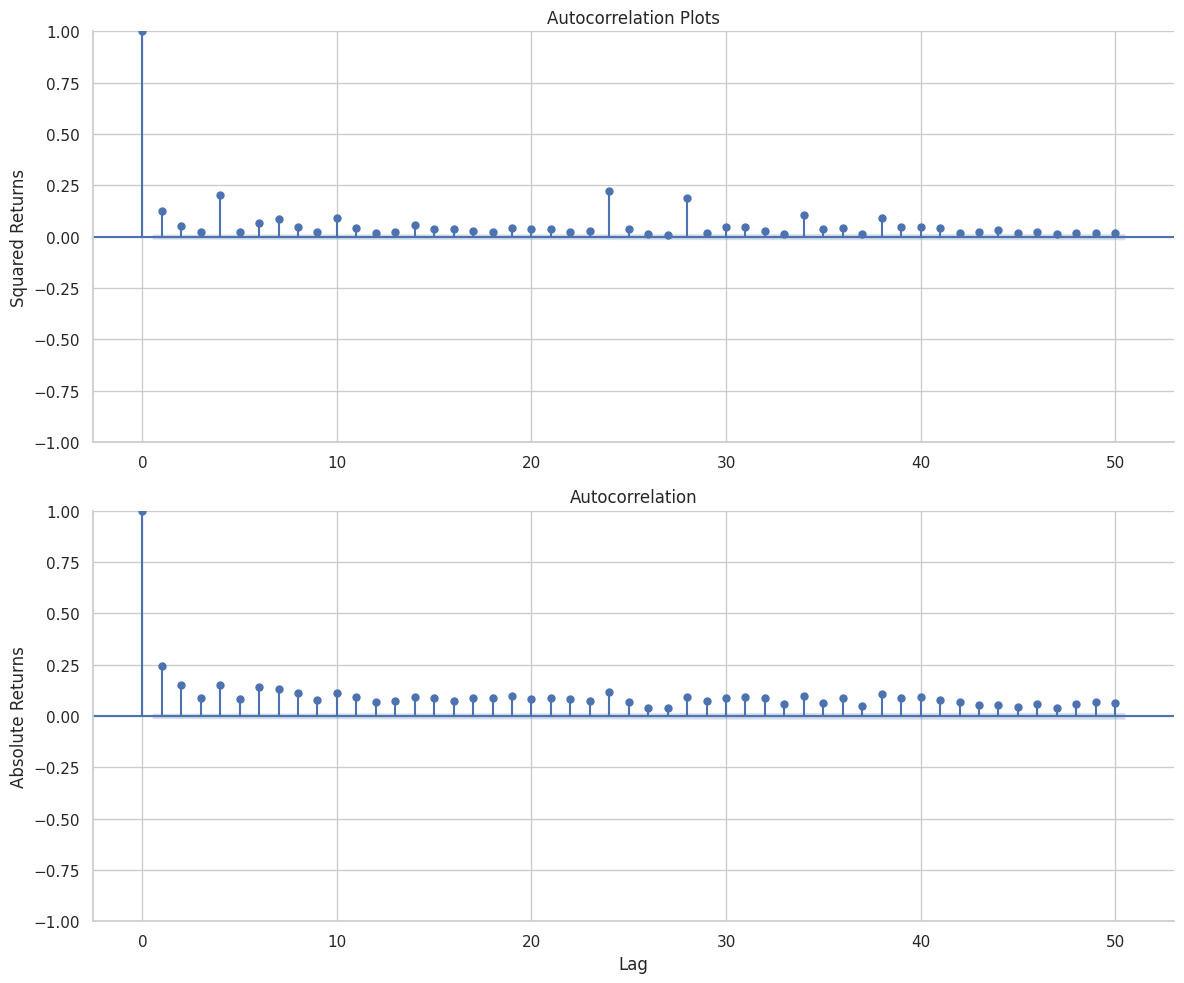

In [ ]:
# Create the ACF plots:
fig, ax = plt.subplots(2, 1, figsize=(12, 10))
smt.graphics.plot_acf(df["log_rtn"]**2, lags=N_LAGS, alpha=SIGNIFICANCE_LEVEL, ax=ax[0])
ax[0].set(title="Autocorrelation Plots", ylabel="Squared Returns")
smt.graphics.plot_acf(np.abs(df["log_rtn"]), lags=N_LAGS, alpha=SIGNIFICANCE_LEVEL, ax=ax[1])
ax[1].set(ylabel="Absolute Returns", xlabel="Lag")

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_4_14", dpi=200);